Math087 - Mathematical Modeling
===============================
[Tufts University](http://www.tufts.edu) -- [Department of Math](http://math.tufts.edu)  
[George McNinch](http://gmcninch.math.tufts.edu) <george.mcninch@tufts.edu>  
*Fall 2020*

Course material (Week 6): Graph models (max flow/min cut)
-------------------------------------------------------------

Graphs more generally
======================

Recall that when we tried to come up with methods for setting up linear programs and solving
them, the only systematic treatment we gave involved a*flow* or *graph* model.

We are now investigate Graph Models in general and discuss max flow and min cut methods that
use duality to understand possible solutions.


Example (aka trains and the cold war?)
----------------------------------

In the mid 1950s, Air Force Researchers Harris and Ross closely studied the rail network of the Soviet Union and the Eastern Bloc countries. They identified 44 “districts” between which rail cargo moved and 105 links between these districts in the rail network. From this, they were able to calculate the maximum shipping capacity from Russia to Europe and,
most importantly, where the “bottleneck” in the network was that limited the capacity. This report was classified until 1999...

This problem, and many others, can be modelled naturally using graphs.

Graphs (definitions)
====================

A graph $G=(V,E)$ is a pair $(V,E)$ consisting of a set $V$ of *nodes* -- or vertices --, 
and a set $E$ of edges.

We say that $G$ is a *directed graph* if $E$ consists of *directed edges*; in this case 
$E$ is a subset of the cartesian product $V \times V$.

If $u,v \in V$ are nodes, a directed edge $e$ of the form $e = (u,v) \in V \times V$ connects the node $u$ to $v$, and is *directional* -- e.g. it is distinct from $e' = (v,u)$, and $e'$ instead connects $v$ to $u$. When such graphs are *drawn*, typically $(u,v)$ is indicated by an *arrow* from node $u$ to node $v$. We might also write the symbol $u \to v$ for this edge.

We say that $G$ is an *undirected graph* if $E$ consists of *undirected edges*. For $u,v \in V$,
the pair determines an undirected edge $[u,v]$, and $[u,v]=[v,u]$. When we draw an undirected graph, an edge $[u,v]$ is indicated just by an undecorated line between $u$ and $v$.


Finally, $G$ is a *weighted (directed or undirected) graph* if we are given a function
$c:E \to \mathbb{R}$ which assigns a *weight* or *capacity* $c(e)$ to each edge $e \in E$. When drawing a weighted graph, we typically *label* the edges with their weights.



Here are a few examples:
========================

Undirected graph
================

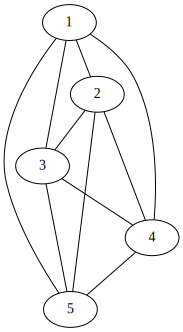

In [1]:
from graphviz import Graph,Digraph
import itertools as it

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

def gg(n):
    gg = Graph('regular graph')
    I = range(1,n)
    for i in I:
        gg.node(f"{i}")

    J = [(i,j) for (i,j) in it.product(I,I) if i<j]

    for (i,j) in J:
        gg.edge(f"{i}",f"{j}")

    return gg

gg(6)

Directed graph
===============

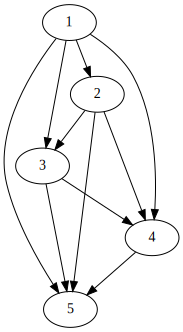

In [2]:
def dg(n):
    dg = Digraph('di-graph')
    I = range(1,n)
    for i in I:
        dg.node(f"{i}")

    J = [(i,j) for (i,j) in it.product(I,I) if i<j]

    for (i,j) in J:
        dg.edge(f"{i}",f"{j}")

    return dg

dg(6)

Weighted di-graph:
===============

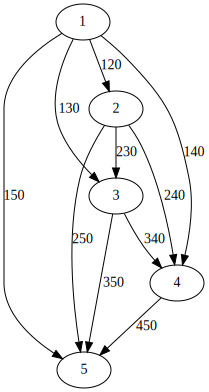

In [3]:

def wdg(n):
    wdg = Digraph('weighted di-graph')
    I = range(1,n)
    for i in I:
        wdg.node(f"{i}")

    J = [(i,j) for (i,j) in it.product(I,I) if i<j]

    for (i,j) in J:
        wdg.edge(f"{i}",f"{j}",f"{100*i+10*j}")

    return wdg

wdg(6)

Example: MBTA!
==============

The weights on the edges give the capacities of the individual lines:

In [4]:
import itertools as it

def mbta():
    mbta = Graph('MBTA-stops',engine='circo')
    I = {1:"Central Sq",
         2:"Hynes",
         3:"Mass Ave",
         4:"Park St",
         5:"Govt Ctr",
         6:"D'town Xing",
         7:"South Stn",
         8:"State St.",
         9:"HayMkt"}
    
    J = {(1,2):50,
         (1,4):200,
         (2,4):200,
         (2,3):50,
         (3,6):100,
         (4,5):150,
         (4,6):200,
         (5,8):100,
         (5,9):100,
         (6,8):100,
         (6,7):200,
         (8,9):100}
        
        
    for i in I.keys():
        mbta.node(f"{I[i]}")

    for (i,j) in J.keys():
        mbta.edge(f"{I[i]}",f"{I[j]}",f"{J[(i,j)]}")

    return mbta

m = mbta()
m.format='png'
m.render()

'MBTA-stops.gv.png'

<img src="MBTA-stops.gv.png" width="650" height="650" />

Maximum Flow
============

Definitions:
------------

Let $G$ be a weighted directed grap. An edge $e \in E$ 
is given by an ordered pair $e=(v,w)$ of vertices; we'll often write
$e = (v \to w)$ for this edge.

We say that a node $v$ is a *source node* if the only edges in $E$ involving $v$ have the form $e = (v \to w)$ -- i.e. "no edges enter $v$"--, and we say that $v$ is a *terminal node* if the only edges in $E$ involving $v$ have the form $e = (w \to v)$ -- i.e. "no edges exit $v$".

We **always assume** that $G$ has exactly one source node $s$ and exactly one terminal node $t$.

Remark: how to make a directed graph from an undirected graph
--------------------------------------------------------------

Suppose that $G$ is an undirected weighted graph with nodes $V$ and edges $E$,
and suppose we have two chosen nodes $s \ne t$.  We consider the weighted
directed graph $\tilde G$ obtained from $G$ by the following rules:
- $\tilde G$ has the same set of nodes $V$ as does $G$
- $s$ is a source in $\tilde G$, and we convert all edges
  $[s,v]=[v,s]$ in $G$ to directed edges $(s \to v)$ in $\tilde G$.
  The weight $c(s \to v)$ is equal to $c([v,s])$.
- $t$ is a terminal node in $\tilde G$, and we convert all edges
  $[t,v] = [v,t]$ in $G$ to directed edges $(v \to t)$ in $\tilde G$. 
  The weight $c(v \to t)$ is equal to $c([v,t])$.
- for any $[v,w]$ with $v,w \not \in \{s,t\}$, there are edges in
  $\tilde G$ in each direction: $(v \to w),(w \to v) \in \tilde E$.
  The weights $c(v\to w)$ and $c(w \to v)$ are both equal to
  $c([v,w])$.

This construction permits us to use some results about directed
graphs to answer questions about undirected graphs, as we shall see
below.


Example:

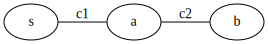

In [5]:
g = Graph("undirected")
g.attr(rankdir='LR')
g.node("a")
g.node("b")
g.node("s")
g.edge("s","a","c1")
g.edge("a","b","c2")

dg = Digraph("directed")
dg.attr(rankdir='LR')
dg.node("a")
dg.node("b")
dg.node("s")

dg.edge("s","a","c1")
dg.edge("a","b","c2")
dg.edge("b","a","c2")

g


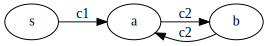

In [6]:
dg

Flows in directed graphs
=========================

As before, let $G$ be a weighted, directed graph.

A *flow* from $s$ to $t$ is a function, $f:E\to \mathbb{R}_{>0}$
that satisfies conditions **(A)** and **(B)**:

**(A)**. $f(e) \le w(e)$ for each edge $e \in E$ in the graph $G$, where $w(e)$ is the value of the weigth function ("the capacity") of the edge $e$.

> If $e = (u \to v)$ we write $f(e) = f(u \to v) = f(u,v)$
> to cut down on the number of parenthesis!




**(B)**. *conservation law* holds for each node $v \in V$ with $v \not \in \{s,t\}$:

$$\sum_{u \,\text{such that}\, (u \to v) \,\text{ is an edge}} f(u \to v) = 
\sum_{u: \,\text{such that}\, (v \to u) \,\text{ is an edge}} f(v \to u)$$

> Note that the RHS is the sum of the values of $f$ for edges coming "into $v$", and the LHS is
> the sum of the values of $f$ for edges going "out of $v$".



Flow value
==========

The *value of the flow $f$* is given by

$$|f| = \sum_{u \in V\, \text{such that}\, (s\to u)\, \text{is an edge}} f(s \to u)$$

where $s$ is the "source" node.




Lemma:
-------

Let $G$ be a directed graph with source $s$ and terminus $t$.
Then $|f|$ can also be expressed using $t$ rather than $s$, as follows:

$$|f| = \sum_{u \in V\, \text{such that}\, (u \to t)\, \text{is an edge}} f(u \to t).$$


Proof:
------

The following two expressions coincide, since each represents the sum $\sum_{e \in E} f(e)$:

$$\sum_{v \in V} \sum_{u \,\text{such that}\, (u \to v) \in E} f(u \to v) 
= \sum_{v \in V} \sum_{u \,\text{such that}\, (v \to u) \in E} f(v \to u).$$



Subtracting the RHS from the LHS we find that

$$0 = \sum_{v \in V} \left(\sum_{u\,\text{such that}\,(u \to v) \in E} f(u \to v) -
\sum_{u\,\text{such that}\,(v \to u) \in E} f(v \to u)
\right).$$

For any $v \in V$ with $v \neq s,t$, the terms in the above sum corresponding to $v$ sum to zero by the conservation law for flows. When $v=s$, there no edges of the form $(u \to s)$ and when $v=t$ there are no edges of the form $(t \to u)$. 

We thus find that

$$0 = (-1) \cdot \sum_{u\,\text{such that}\, (s \to u)} f(s \to u) + \sum_{u\,\text{such that}\, (u \to t)} f(u \to t)$$

and the Lemma follows at once.

--------------------

Flow as a linear program
-------------------------

We are interested in the question: how to maximize the flow from the source to the terminus of the network?

Note that $f$ is just determined by an assignment of a real number to each edge $e = (u \to v) \in E$, in some sense $f$ is just a vector of length $\#E$.

Our goal is: ``maximize`` $|f|$

subject to $0 \le f(u \to v) \le c(u \to v)$ for each edge $u \to v \in E$

and subject to the **conservation laws**:

$\displaystyle 0 = \sum_{u\, \text{such that}\, (u \to v) \in E} f(u \to v) - 
\sum_{u\, \text{such that}\, (v \to u) \in E} f(v \to u)$ for each node $v \neq s,t$.

We have just described a linear program; an optimal solution to this linear program is known as ``max flow``.


Our goal in these notes is to consider the dual of this linear program, and to observe that information from the dual tells us something useful about the ``max flow`` problem.

--------------------------------------

We pause to formulate the following:

A remark about dual linear programs
===================================

Consider the linear program $\mathcal{L}$:

``maximize`` $\mathbf{c} \mathbf{x}$

subject to: *inequality constraint(s)* $A \mathbf{x} \le \mathbf{b}$ and $\mathbf{x} \ge \mathbf{0}$

*equality constraint* $B \mathbf{x} = \mathbf{0}$.

Then $\mathcal{L}$ isn't in standard form, but nevertheless we'd like to take the dual without having to make a complicated "change of variables."

Now each row $\mathbf{r}$ of the matrix $B$ as determine an equality
constraint $\mathbf{r}\mathbf{x} = 0$, which is equivalent to two inequality constraints

$$\mathbf{r}\mathbf{x} \le 0 \quad \text{and} \quad \mathbf{r} \mathbf{x} \ge 0$$



If the rows of $B$ are $\mathbf{r}_1,\dots,\mathbf{r}_s$, and if $A$ is an $r \times n$ matrix, then we form
a new $(r+s)\times n$ matrix $A_1$ and vector
$\mathbf{b_1} \in \mathbb{R}^{r+2s}$ as follows:
$$A_1 = \begin{bmatrix} 
A \\
\mathbf{r}_1 \\
\vdots \\
\mathbf{r}_s \\
\end{bmatrix} \quad \text{and} \quad
\mathbf{b_1} = \begin{bmatrix}
\mathbf{b} \\ 
0 \\
\vdots \\
0 
\end{bmatrix}.$$

The condition $A_1 \mathbf{x} \le \mathbf{b_1}$ is equivalent to the pair of conditions $A \mathbf{x} \le \mathbf{b}$ and $B \mathbf{x} \le \mathbf{0}$.



Consider a "dual vector" of the following form:

$$\mathbf{y} = \begin{bmatrix} y_1 & y_2 & \cdots & y_r & p_1 & \cdots & p_s \end{bmatrix}^T$$

where the $y_1,\dots,r_r$ are labelled by the rows of $A$ and $p_1,\dots,p_s$ are labelled by the rows of $B$.

### Lemma:

The linear program $\mathcal{L'}$ dual to $\mathcal{L}$ can be described as follows: ``minimize`` $\mathbf{b_1}^T \cdot \mathbf{y}$ subject to:

- $A_1^T \mathbf{y} \ge \mathbf{c}$, 

- $y_i \ge 0$ for $1 \le i \le r$, and $p_i \in \mathbb{R}$ for $1 \le i \le s$.


**Sketch of proof:**

In fact, $\mathcal{L}$ can be put in standard form using a slightly more complicated matrix $\widetilde A_1$ than $A_1$: namely, instead of simply including each row $\mathbf{r}_i$, one should instead include
two rows: one equal to $\mathbf{r}_i$ and another equal to $-\mathbf{r}_i$. And $\widetilde{\mathbf{b}_i}$ should end with $2s$ zeros.

Then the condition $\widetilde{A_1} \mathbf{x} \le \widetilde{ \mathbf{b_1}}$ is equivalent
to the pair of conditions $A \mathbf{x} \le \mathbf{b}$ and $B \mathbf{x} = \mathbf{0}$.

Taking transposes, the transpose of $\widetilde{A_1}$ leads to dual variables
$y_1,\dots,y_r,p_{1,+},p_{1,-},\dots,p_{s,+},p_{s,0}$ which satisfy $y_i \ge 0, p_{i,\pm} \ge 0$.

Now, one sets $p_i = p_{i,+} - p_{i,-}$, and a bit of thought leads to the conclusion of the lemma.

-------------------

Linear program for flows
-------------------------

Lets write $V^o$ for the set of all vertices *except* $s,t$; thus
$$V^o = V \setminus \{s,t\}$$
and $\# V^o = \# V - 2$.

Now consider the linear program:

``maximize`` $|f|$

subject to:  

*inequality constraints*: $f(u \to v) \le c(u,v)$ for $(u \to v) \in E$, and

$f(u \to v) \ge 0$ for $(u \to v) \in E$,

*equality constraints*:

$$\displaystyle \sum_{u\, \text{such that}\, (u \to v) \in E} f(u \to v) 
- \sum_{u\, \text{such that}\, (v \to u) \in E} f(v \to u) = 0\quad \text{for} \quad v \in V^o.$$


The dual linear program
-----------------------

Consider the dual to the linear program just described; note that we have some equality constraints.

As discussed a above, we are led to the dual linear program with $\# E + \# V^o$ dual variables;
we write these as

$d(u \to v)$ for $(u \to v) \in E$ 

and

$p(u)$ for $u \in V^o$

Note 
- $d(u \to v) \ge 0$ since these are the variables corresponding to rows of the primal inequality constraint matrix, while  
- $p(u) \in \mathbb{R}$ since these are the variables corresponding to rows of the primal equality constraint matrix.


    

The dual objective function has entries $c(u \to v)$ for the edges, and $0$ for the $u \in V^o$.

We now find that the dual program is given as follows:

``minimize`` $\displaystyle \sum_{(u \to v) \in E} c(u \to v) d(u \to v)$ 

subject to:

$d(s \to v) + p(v) \ge 1$ for $(s \to v) \in E$, $v \neq t$,

$d(u \to v) - p(u) + p(v) \ge 0$ for all $(u \to v) \in E$, provided $\{u,v\} \cap \{s,t\} = \emptyset$,

$d(v \to t) - p(v) \ge 0$ for all $(v \to t) \in E$, $v \neq s$,

$p(u),d(v \to w) \ge 0$ for every $u \in V^o$ and every $(v \to w) \in E$.

A small-ish example
======================

Rather than confirm the inequalities for the dual program in general, let's see them for a simple example, since it mostly illustrates the main ideas.



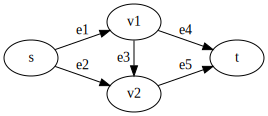

In [7]:
simple = Digraph()
simple.attr(rankdir='LR')

with simple.subgraph() as c:
    c.attr(rank='same')
    c.node("v1")
    c.node("v2")

simple.node("s")
simple.node("t")

simple.edge("s","v1","e1")
simple.edge("s","v2","e2")

simple.edge("v1","v2","e3")

simple.edge("v1","t","e4")
simple.edge("v2","t","e5")

simple

For this graph, the ``max-flow`` linear program may be described as follows:

``maximize`` $\mathbf{c} \cdot \mathbf{f} = f_1 + f_2$ where $\mathbf{c} = \begin{bmatrix} 1 & 1 & 0 & 0 & 0 \end{bmatrix}$.

subject to: 

$f_i \le e_i$ for $1 \le i \le 5$

$f_1 - f_3 - f_4 = 0$

$f_2 + f_3 - f_5  = 0$

$f_i \ge 0$ for $1 \le i \le 5$


Now, the dual program has variables $\mathbf{y} = \begin{bmatrix} \mathbf{d} \\ \mathbf{p} \\ \end{bmatrix}$, where $\mathbf{d} \in \mathbb{R}^5$ and $\mathbf{p} \in \mathbb{R}^2$.

The objective function is determined by $\begin{bmatrix} e_1 & e_2 & e_3 & e_4 & e_5 & 0 & 0  \end{bmatrix}$, 

and the inequality constraint is given by

$A_1^T \cdot \mathbf{y} \ge \begin{bmatrix} 1 & 1 & 0 & 0 & 0 \end{bmatrix}^T$

where

$$A_1 = \begin{bmatrix}
I_5 \\
\begin{matrix}
1 & 0 & -1 & -1 & 0 \\
0 & 1 & 1 & 0 & -1
\end{matrix}
\end{bmatrix}$$
and where $I_5$ is the $5 \times 5$ identity matrix.


Thus, we maximize $\sum_{i=1}^5 d_i e_i$ subject to

$d_1 + p_1  \ge 1$

$d_2 + p_2 \ge 1$

$d_3 - p_1 + p_2 \ge 0$

$d_4 - p_1 \ge 0$

$d_5 - p_2 \ge 0$

$d_i,p_j \ge 0$ all $i,j$.

We can now observe an interesting property of the solutions of the dual linear program to the flow program.

Let's compute solutions for a bunch of *randomly generated* capacities $e_1,e_2,e_3,e_4$.

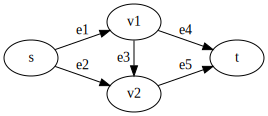

In [8]:
simple

In [9]:
import numpy as np
from scipy.optimize import linprog

float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

def sbv(index,size):
    return np.array([1.0 if i == index-1 else 0.0 for i in range(size)])

# Whoops -- my original version had a typo in the 4th row here!
# 
#B=np.block([[ sbv(1,5) , np.array([ 1, 0]) ],
#            [ sbv(2,5) , np.array([ 0, 1]) ],
#            [ sbv(3,5) , np.array([-1, 1]) ],
#            [ sbv(4,5) , np.array([ 1, 0]) ],
#            [ sbv(5,5) , np.array([ 0,-1]) ]])


B=np.block([[ sbv(1,5) , np.array([ 1, 0]) ],
            [ sbv(2,5) , np.array([ 0, 1]) ],
            [ sbv(3,5) , np.array([-1, 1]) ],
            [ sbv(4,5) , np.array([ -1, 0]) ],
            [ sbv(5,5) , np.array([ 0,-1]) ]])


b=np.array([1,1,0,0,0])

bounds = np.array(5*[(0,None)] +  2*[(None,None)])

def f():
    # randomly generate capacities
    c = np.random.rand(5)
    e = np.block([np.random.rand(5),np.array([0,0])])
    # solve the dual linear program
    res = linprog(e,A_ub=(-1)*B,b_ub=(-1)*b)
    print(f"capacities = {c}\nresult     = {res.x}\n")

for i in range(10):
    f()


capacities = [0.37 0.78 0.63 0.71 0.94]
result     = [0.00 0.00 0.00 1.00 1.00 1.00 1.00]

capacities = [0.91 0.12 0.18 0.49 0.11]
result     = [1.00 1.00 0.00 0.00 0.00 0.00 0.00]

capacities = [0.62 0.69 0.30 0.74 0.11]
result     = [0.00 0.00 0.00 1.00 1.00 1.00 1.00]

capacities = [0.22 0.60 0.02 0.66 0.68]
result     = [1.00 0.00 0.00 0.00 1.00 0.00 1.00]

capacities = [0.43 0.75 0.80 0.12 0.29]
result     = [1.00 1.00 0.00 0.00 0.00 0.00 0.00]

capacities = [0.02 0.46 0.60 0.57 0.59]
result     = [1.00 1.00 0.00 0.00 0.00 0.00 0.00]

capacities = [0.49 0.02 0.87 0.09 0.17]
result     = [1.00 1.00 0.00 0.00 0.00 0.00 0.00]

capacities = [0.69 0.31 0.59 0.57 0.19]
result     = [1.00 1.00 0.00 0.00 0.00 0.00 0.00]

capacities = [0.97 0.26 0.59 0.35 0.07]
result     = [1.00 0.00 0.00 0.00 1.00 0.00 1.00]

capacities = [0.43 0.53 0.11 0.64 0.91]
result     = [0.00 0.00 0.00 1.00 1.00 1.00 1.00]



We see in every case that the result -- i.e. the solution to the dual problem --
gives an optimal solution for which
$d_i,p_j \in \{0,1\}$ for all $i,j$.

This is true quite generally, as we are now going to explain.

Totally unimodular matrices
===========================

We are going to invoke (but not prove!) the following important result:

Theorem
-------

Consider a linear program in standard form given by $(\mathbf{c}, A,\mathbf{b})$.
Suppose that $\mathbf{b} \in \mathbb{Z}^r$, that $A$ is *totally unimodular*,
and that there is at least one optimal solution.
Then there is an optimal solution $\mathbf{x} \in \mathbf{Z}^n$ -- i.e. an *integral* optimal solution*.

**NB.** The matrix $A$ is *totally unimodular* if every equal submatrix of $A$ has determinant equal to $0,1,$ or $-1$.


Max flow and min cut
--------------------

If $\mathcal{L}$ is the "flow" linear program determined by a directed graph,
then the inequality constraint $B \mathbf{y} \ge \mathbf{e}$ for the dual linear program $\mathcal{L}'$ is given by a totally unimodular matrix $B$, and the vector $\mathbf{e}$ has integer entries. 

According to the preceding Theorem, if $\mathcal{L}'$ has an optimal solution, it must have an optimal solution with integer coefficients.

Recall that the variable vector $\mathbf{y}$ for $\mathcal{L}'$ has entries
$d(u \to v)$ for edges $(u \to v)$ in the graph, and entries $p(v)$ for nodes $v \in V^o$ i.e. nodes $v \neq t,s$.

We introduce value $p(s) = 1$ and $p(t) = 0$, and we note with these notations, the constraints of $\mathcal{L}'$ (described above) may be reformulated as follows:

$d(u \to v) - p(u) + p(v) \ge 0 \quad \text{for all} \quad (u \to v) \in E.$

$p(s) = 1$ and $p(t) = 0$

$p(u) \in \mathbf{R}$

$d(u \to v) \ge 0$



Suppose now that we have chosen an optimal solution with all $d(u\to v), p(v)  \in \mathbb{Z}$.

This solution minimizes the quantity

$$(\heartsuit) \quad \sum_{u \to v} d(u \to v) c(u\to v).$$

In fact, there is an optimal integral solution $p,d$ as above with the following properties:

$d(u \to v) \in \{0,1\}$ for each edge $u \to v$.  
$p(u) \in \{0,1\}$ for each node $u \in V$.  
$d(u \to v) = 0$ whenever $p(u) = p(v)$.  
$d(u \to v) = 1$ if $p(u) = 1$ and $p(v) = 0$.

Observe that $p$ determines a *partition* of the nodes. Indeed, we can view nodes $u$ for which $p(u) = 0$ as being "grouped with $t$" and nodes for which $p(u) = 1$ as being "grouped with $s$".


One sees that $(\heartsuit)$ represents the sum of capacities of all edges which connect a node in the $s$-group with a node in the $t$-group. This leads to the ``min-cut`` description:

Theorem (``min cut``)
-------
Consider the primal linear program "maximize the flow value" for a directed graph, and consider
the dual linear program.
An optimal solution to the dual program is obtained by considering all partitions of the nodes $V$ into two groups -- one group containing $s$ and one containing $t$ -- and computing the sum of the capacities of all edges  connecting the $s$-group to the $t$-group. The minimal such sum 
is the optimal value.




Using strong duality for linear programs, one sees immediately

Corollary
---------

The maximum value of $|f|$ for a flow is found by computing the ``min cut``.


Example
--------
Let's return to the MBTA example introduced earlier. More precisely, let's find the maximum hourly flow between Park Street and Downtown Crossing.

Well, by duality it is the same to solve the ``min cut`` problem. Thus, we need to cut paths between a "Park street" group and a "Downtown Crossing" group.


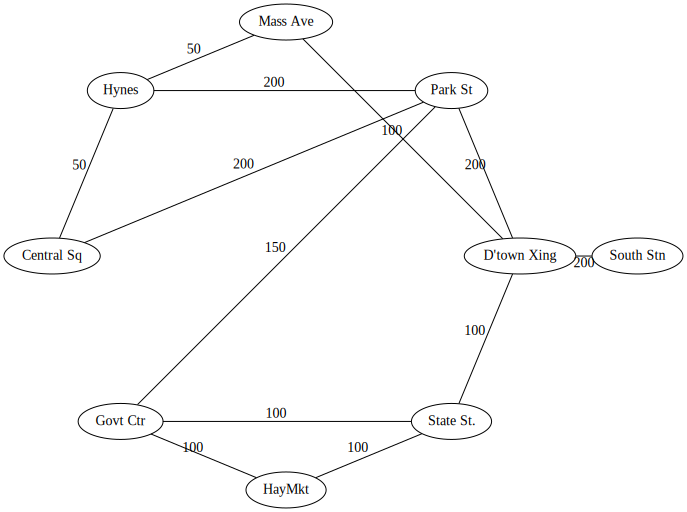

In [10]:
#<img src="MBTA-stops.gv.png" width="650" height="650" />

mbta()

Remark: we must interpret this *undirected* graph as a directed graph with source "Park St" and terminus "Downtown Crossing", as discussed before.

In this case, the ``min cut`` is achieved by cutting the following connections:

- Park St to Downtown Crossing (capacity 200)
- Downtown Crossing to State (capacity 100)
- Hynes to Mass Ave (capacity 50)

This gives the partition:

Park St group:

  { Park St, Hynes, State, Central, Govt Centerr, Haymarket}
  
Downtown Crossing group:

  { Downtown Crossing, Mass Ave, South Station }

The ``min cut`` value is 350, and it follows by duality that the maximum flow between Park St and Downtown Crossing is 350 people per hour. 